In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_util
from tensorflow.python.ops import check_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops.distributions import bijector

from tensorflow.contrib.distributions import Normal
from tensorflow.python.ops import nn
from pymisca.transformed_distribution import TransformedDistribution
# array_ops.gather_nd?

/home/shouldsee/.local/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#### Adapted from: http://kyleclo.github.io/maximum-likelihood-in-tensorflow-pt-1/

import numpy as np

D = 2


TRUE_MU = 0.0
TRUE_SIGMA = 2.0
SAMPLE_SIZE = (5000,D)

np.random.seed(0)
x_obs = np.random.normal(loc=TRUE_MU, scale=TRUE_SIGMA, size=SAMPLE_SIZE)
rsq = np.square(x_obs).sum(axis=-1)
keep = rsq > np.mean(rsq)
x_obs = x_obs[keep]

# x_obs.T[0] = x_obs.T[0]*0.1

# x_obs = np.square(x_obs)


In [3]:
import pymisca.tensorflow_extra as pytf
reload(pytf)




from tensorflow.python.ops import nn
import tensorflow as tf

# data
x = tf.placeholder(dtype=tf.float32)

INIT_MU_PARAMS = {'loc': 0.0, 'scale': 0.1}
INIT_PHI_PARAMS = {'loc': 1.0, 'scale': 0.1}
RANDOM_SEED = 0

# params
np.random.seed(RANDOM_SEED)
mu = nn.softplus(tf.Variable(initial_value=np.random.normal(**INIT_MU_PARAMS),
                 dtype=tf.float32)
                )
phi =nn.softplus( tf.Variable(initial_value=np.random.normal(**INIT_PHI_PARAMS),
                  dtype=tf.float32)
                )
sigma =nn.softplus( tf.Variable(initial_value=np.random.normal(size=(D,),
                                                               **INIT_PHI_PARAMS),
                  dtype=tf.float32)
                )

# sigma = tf.square(phi)

# loss

def makeEMD( (mu,phi,sigma) ):
    dist_rsq = tf.contrib.distributions.Gamma(concentration=mu,rate=phi)

    #### Use a bijector to calculate P(x) from P(r^2)
    dist_xyz = mdl = pytf.AsRadial(distribution=dist_rsq,
                                   D=D)
    
    ### Allow an affine transformation y = M x + x_0
#     dist_aff = mdl = pytf.AffineTransformDiag(distribution=dist_xyz,
#                                         scale_diag=sigma,)
    
#     mdl = dist_aff
    
    # gaussian_dist = tf.contrib.distributions.Normal(loc=mu, scale=sigma)
    # mdl  = dist_rsq
    return mdl


fitted_vars = [mu,phi,sigma]
emission = makeEMD(fitted_vars)

Xmd = np.random.random((100,200,3)).astype(np.float32)
bjt = emission.bijector
# bjt = emission.distribution.bijector
xTheta = bjt.inverse(Xmd)
print (xTheta.shape)

fldj =val= bjt.forward_log_det_jacobian(xTheta,event_ndims=0)
print (val.shape)

ildj = bjt.inverse_log_det_jacobian(Xmd,event_ndims=1)
print (val.shape)

# assert 0

[WARN]unable to import edward.models
[WARN]unable to import edward.models
(100, 200)
(100, 200)
(100, 200)


In [4]:
fitted_vars = [mu,phi,sigma]
emission = makeEMD(fitted_vars)
log_prob = emission.log_prob(value=x)
neg_log_likelihood = -1.0 * tf.reduce_sum(log_prob)


# gradient
grad = tf.gradients(neg_log_likelihood, fitted_vars)

In [5]:
#### Adapted from: http://kyleclo.github.io/maximum-likelihood-in-tensorflow-pt-1/
reload(pytf)
LEARNING_RATE = 0.1
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
sess,last_vars, hist_loss, opt = pytf.op_minimise(
    neg_log_likelihood,
    fitted_vars,
    optimizer,
    feed_dict = {x: x_obs}
)

[WARN]unable to import edward.models
Iter 0 69559500.0
Iter 100 11530804.0
Iter 200 11428459.0
Iter 300 11371827.0
Iter 400 11345674.0
Iter 500 11334792.0
Iter 600 11330675.0
Loss function convergence in 684 iterations!: 11329422.0


is in ipython: 1
is in ipython: 1
[WARN] pymisca.vis_util cannot find network


/home/shouldsee/.local/lib/python2.7/site-packages/scipy/cluster/vq.py:78: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _vq
/home/shouldsee/.local/lib/python2.7/site-packages/scipy/cluster/hierarchy.py:178: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _hierarchy, _optimal_leaf_ordering
/home/shouldsee/.local/lib/python2.7/site-packages/scipy/cluster/hierarchy.py:178: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _hierarchy, _optimal_leaf_ordering


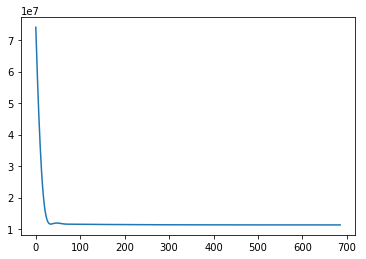

In [6]:
import pymisca.vis_util as pyvis
%matplotlib inline 

plt = pyvis.plt
plt.plot(hist_loss)

In [7]:
print (last_vars)

[5.242469, 0.3390981, array([1.3857405, 1.481847 ], dtype=float32)]


In [8]:
with sess.as_default():
    print ([x.eval() for x in emission.distribution._graph_parents])

[5.242469, 0.3390981]


Instructions for updating:
dim is deprecated, use axis instead


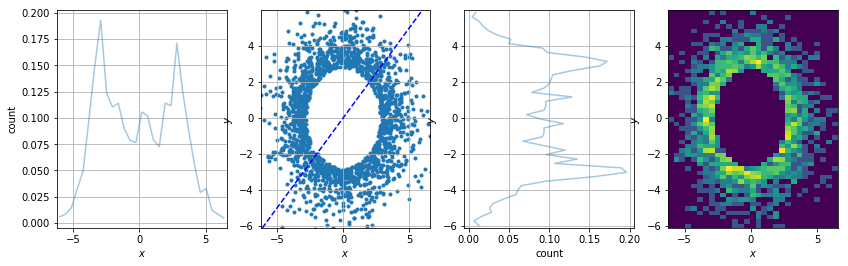

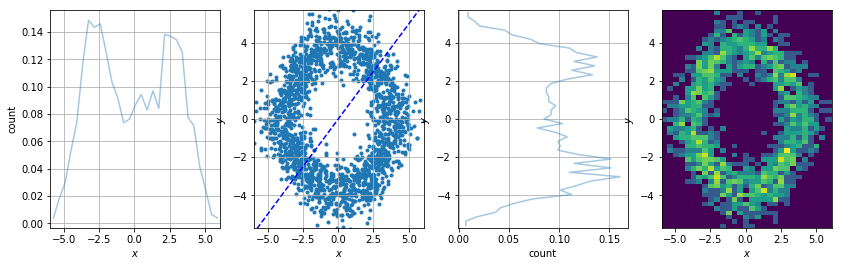

In [9]:
with sess.as_default():
# sess = tf.InteractiveSession()
# if 1:
    EMD = makeEMD(last_vars)
    X = x_obs
    Y = EMD.sample(len(X)).eval()

    pyvis.qc_2var(X.T[0],X.T[1])
    pyvis.qc_2var(Y.T[0],Y.T[1])